# 0 Overview
In this notebook, we'll learn how to find the steady-state policy and distribution of the discrete-time *standard incomplete markets model*. The Bellman equation for this model is

$$
\begin{gather}
V(s,a)=\max_{c,a'} u(c)+\beta\mathbb{E}[V(s',a')|s] \tag{1}\\
\text{s.t. }a'+c=(1+r)a+y(s) \tag{2}\\
a'\geq \underline{a} \tag{3} \\
\end{gather}
$$

Here, households earn stochastic income $y(s)$ that depends on some exogenous state $s$ that follows a discrete Markov chain, and also earn returns $ra$ on their incoming assets. They split their *cash on hand* $(1+r)a+y(s)$ between assets saved for tomorrow $a'$ and consumption today $c$ in order to maximize expected utility, subject to a borrowing constraint $a'\geq \underline{a}$.

We will implement this model in several steps, each corresponding to a section of this notebook:

**[Section 1: discretizing assets and income](#section1)**. We'll discretize the continuum of possible asset states $a$ into a finite grid, and also calibrate the Markov chain for $s$ such that $\log y(s)$ is approximately AR(1) with normal innovations.


**[Section 2: backward iteration to obtain the policy function](#section2)**. We'll use backward iteration with the endogenous gridpoints method to solve the Bellman equation (1). This gives us steady-state consumption and asset policy functions $c(s,a)$ and $a'(s,a)$ on the discrete grid of states $(s,a)$ from section 1.


**[Section 3: forward iteration to obtain the distribution](#section3)**. We'll use forward iteration with the asset policy function from section 2 to find the steady-state distribution, i.e. the mass $D(s,a)$ of households at each gridpoint $(s,a)$. Since households will generally not choose exactly a gridpoint as their asset policy, we'll use a "lottery" method (a form of linear interpolation) to allocate them between gridpoints.


**[Section 4: combining everything and aggregating](#section4)**. 
Combining the policy function and distribution from sections 2 and 3, we obtain aggregate consumption and asset holdings. We can use these to calibrate the model, or solve for a simple general equilibrium steady state.


The code developed in this notebook is in included in the `sim_steady_state.py` module, which is an excellent place to get a concise overview of everything developed here.


This notebook does not focus on speed, although the code ends up having decent performance. We will discuss how to improve performance in another tutorial. 


**Preliminaries**. Before we start, we need to import the Python libraries that we'll be using:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy import optimize

<a id='section1'></a>

# 1 Discretizing assets and income
*Note: this section is included for completeness, but the details here are not required to understand later sections, and readers who want to move ahead to the [core material in section 2](#section2) are encouraged to skim here.*

## 1.1 Discretizing the asset space
In principle, households pick assets from the interval $[\underline{a},\infty)$. Computationally, however, our methods require a finite grid of asset levels, and use linear interpolation to evaluate points off this grid.

For simplicity, we will use the same grid to calculate the policy function and also to calculate the distribution.

How should this grid be chosen? It turns out that for both the policy function and the distribution, we need:

- densely spaced points near the borrowing constraint $\underline{a}$, where the policy function is highly nonlinear and many households cluster.


- sparsely spaced points going up to a very high level of assets, to ensure we capture the wealthiest households; at these high asset levels, the policy function becomes asymptotically linear (making linear interpolation accurate) and the distribution becomes smooth.

A simple and effective way to produce such a grid is to do a **double-exponential transformation** of a uniformly spaced grid. Starting with uniformly spaced points $u_i$ on an interval $[0,\bar{u}]$, we construct gridpoints $a_i$ by applying the transformation

$$
a_i = \underline{a} + e^{e^{u_i}-1}-1 \tag{4}
$$

This produces a grid with minimum $\underline{a}$ and maximum $\underline{a} + e^{e^{\bar{u}}-1}-1$. To equate the latter with some desired maximum asset gridpoint $\bar{a}$, we write $\bar{u} = \log(1+\log(1+ \overline{a} - \underline{a}))$.

We implement this in the function below.

In [4]:
def discretize_assets(amin, amax, n_a):
    # find maximum ubar of uniform grid corresponding to desired maximum amax of asset grid
    ubar = np.log(1 + np.log(1 + amax - amin))
    
    # make uniform grid
    u_grid = np.linspace(0, ubar, n_a)
    
    # double-exponentiate uniform grid and add amin to get grid from amin to amax
    return amin + np.exp(np.exp(u_grid) - 1) - 1

Let's see the results, if we want a grid with 50 points between 0 and 10,000. (Normally, we'll want more than that, but this is easier to visualize.)

In [5]:
a_grid = discretize_assets(0, 10_000, 50)
with np.printoptions(precision=2):
    print(a_grid)

[0.00e+00 4.98e-02 1.05e-01 1.65e-01 2.32e-01 3.07e-01 3.90e-01 4.82e-01
 5.86e-01 7.03e-01 8.34e-01 9.83e-01 1.15e+00 1.34e+00 1.57e+00 1.82e+00
 2.11e+00 2.45e+00 2.85e+00 3.31e+00 3.86e+00 4.51e+00 5.29e+00 6.21e+00
 7.34e+00 8.70e+00 1.04e+01 1.24e+01 1.50e+01 1.82e+01 2.23e+01 2.75e+01
 3.42e+01 4.29e+01 5.43e+01 6.96e+01 9.01e+01 1.18e+02 1.57e+02 2.11e+02
 2.87e+02 3.97e+02 5.58e+02 7.97e+02 1.16e+03 1.71e+03 2.58e+03 3.97e+03
 6.23e+03 1.00e+04]


We see here the vastly greater concentration of gridpoints near the borrowing constraint: out of 50, the first 12 points are less than 1, the next 10 points are less than 5, and so on. Similarly, we see the thinly spaced points near the top: 6 points cover almost the entire span from 1000 to 10,000. With the *double* exponential, the ratio between each pair of successive points grows as we go higher on the grid.

There are many variations on this theme: we could add scalar parameters in (2) to tinker with the spacing, use a triple exponential as in [Carroll](http://www.econ2.jhu.edu/people/ccarroll/EndogenousGridpoints.pdf), and so on. But the basic double exponential is a good and robust option.

## 1.2 Discretizing an AR(1) to obtain a Markov chain for incomes
We set up the standard incomplete markets model under the assumption that there was a finite set of exogenous states $s$, each with income $y(s)$, and where the state of each household follows a Markov process with some probability $\pi_{ss'}$ of moving from any state $s$ to any state $s'$.

Sometimes it makes sense theoretically to have a income process with a few exogenous states: for instance, in a simple model we might have two states, for "employment" and "unemployment". But more generally, we think of this as a discrete approximation to a continuous income process—for instance, an AR(1) with persistence $\rho$ and normal innovations $\epsilon_t$:

$$
\log y_t = \rho \log y_{t-1} + \epsilon_t \tag{5}
$$

The question is then how we can get a good approximation to the properties of the continuous process (5) with a Markov chain on finitely many states.

There are several methods to discretize an AR(1) process with normal innovations. One of the most famous is the [Tauchen (1986) method](https://doi.org/10.1016/0165-1765(86)90168-0). Here, we will use the **Rouwenhorst method**, [summarized and elaborated upon by Kopecky and Suen](http://www.karenkopecky.net/Rouwenhorst_WP.pdf).

One way to interpret this method is that it models the sum $s$ of $n-1$ independent hidden states, each of which can take the value 0 or 1, and each of which have a probability $p$ of staying at the current value and a probability $1-p$ of switching. There are $n$ possible values for this sum, ranging from 0 to $n-1$. As $n$ becomes higher, the sum $s$ behaves more and more like an AR(1) with normal innovations.

One can show that the Markov transition matrix $\Pi_n$ between possible values of the sum $s$ obeys the recursion

$$
\Pi_{n}=p\begin{bmatrix}\Pi_{n-1} & \mathbf{0}\\
\mathbf{0}' & 0
\end{bmatrix}+(1-p)\begin{bmatrix}\mathbf{0} & \Pi_{n-1}\\
0 & \mathbf{0}'
\end{bmatrix}+(1-p)\begin{bmatrix}\mathbf{0}' & 0\\
\Pi_{n-1} & \mathbf{0}
\end{bmatrix}+p\begin{bmatrix}0 & \mathbf{0}'\\
\mathbf{0} & \Pi_{n-1}
\end{bmatrix} \tag{6}
$$

with base case

$$
\Pi_{2}=\begin{bmatrix}p & 1-p\\
1-p & p
\end{bmatrix} \tag{7}
$$

The following function implements this recursion to return any desired $\Pi_n$.

In [6]:
def rouwenhorst_Pi(N, p):
    # base case Pi_2
    Pi = np.array([[p, 1 - p],
                   [1 - p, p]])
    
    # recursion to build up from Pi_2 to Pi_N
    for n in range(3, N + 1):
        Pi_old = Pi
        Pi = np.zeros((n, n))
        
        Pi[:-1, :-1] += p * Pi_old
        Pi[:-1, 1:] += (1 - p) * Pi_old
        Pi[1:, :-1] += (1 - p) * Pi_old
        Pi[1:, 1:] += p * Pi_old
        Pi[1:-1, :] /= 2
        
    return Pi

In a random sequence of sums $s_t$ drawn using any such $\Pi_n$, one can show that the "persistence" $\rho$ from regressing $s_t$ on $s_{t-1}$ is $2p-1$. For this to match a given AR(1) persistence $\rho$, therefore, we must choose $p=(1+\rho)/2$.

Also, each $s_t$ is a sum of $n-1$ independent states that ultimately have a 50-50 probability of being 0 or 1, so its stationary distribution is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) with $n-1$ trials and success probability 1/2. This has standard deviation $\sqrt{n-1}/2$, so if we want to match a given cross-sectional standard deviation of log income, we should scale each $s_t$ by the constant $\alpha \equiv 2\sigma/\sqrt{n-1}$.

We can also add a constant $C$ to change the mean of $s_t$, but after we exponentiate this will end up scaling income by $e^C$. We'll pick the latter scaling factor directly to achieve a desired level of average income (in our case, a simple normalization of 1).

First, we need to write code that finds the stationary distribution of a Markov chain with transition matrix $\Pi$. A simple and robust way to do this is to repeatedly apply the transition matrix, updating the distribtion $\pi$ to $\Pi'\pi$, until convergence up to some tolerance. (Note that `@` is matrix multiplication in Python, and `.T` gives the transpose.)

In [7]:
def stationary_markov(Pi, tol=1E-14):
    # start with uniform distribution over all states
    n = Pi.shape[0]
    pi = np.full(n, 1/n)
    
    # update distribution using Pi until successive iterations differ by less than tol
    for _ in range(10_000):
        pi_new = Pi.T @ pi
        if np.max(np.abs(pi_new - pi)) < tol:
            return pi_new
        pi = pi_new

Now we'll put together our insights to obtain a discretized income process.

In [8]:
def discretize_income(rho, sigma, n_s):
    # choose inner-switching probability p to match persistence rho
    p = (1+rho)/2
    
    # start with states from 0 to n_s-1, scale by alpha to match standard deviation sigma
    s = np.arange(n_s)
    alpha = 2*sigma/np.sqrt(n_s-1)
    s = alpha*s
    
    # obtain Markov transition matrix Pi and its stationary distribution
    Pi = rouwenhorst_Pi(n_s, p)
    pi = stationary_markov(Pi)
    
    # s is log income, get income y and scale so that mean is 1
    y = np.exp(s)
    y /= np.vdot(pi, y)
    
    return y, pi, Pi

Let's test out our function on $\rho=0.975$, $\sigma=0.7$, and $n_s=7$. The former two values roughly match some estimates of the quarterly persistence, and the standard deviation, of the persistent component of log income in the US.

In [9]:
y, pi, Pi = discretize_income(0.975, 0.7, 7)

The income states and their probabilities:

In [10]:
y, pi

(array([0.1413694 , 0.25036602, 0.44339966, 0.78526334, 1.3907059 ,
        2.46294815, 4.36189534]),
 array([0.015625, 0.09375 , 0.234375, 0.3125  , 0.234375, 0.09375 ,
        0.015625]))

Let's verify that the targeted mean, standard deviation, and persistence are all correct. First, the mean of the level of income is 1 (we take the dot product of `pi` and `y` because we want to sum the incomes `y` weighted by their population frequencies `pi`):

In [11]:
np.vdot(pi, y)

0.9999999999999999

Second, the standard deviation of log income is $\sigma=0.7$ (note that `**` is exponentiation in Python):

In [12]:
log_y = np.log(y)
mean_log_y = np.vdot(pi, log_y)
sd_log_y = np.sqrt(np.vdot(pi, (log_y - mean_log_y)**2))
sd_log_y

0.7000000000003476

Finally, the persistence of log income is $\rho=0.975$. One way to see this is that in every state, the expected value of log income in the next period relative to the mean is $\rho$ times the value in this period.

In [13]:
log_y_minus_mean = log_y - mean_log_y
log_y_minus_mean_expected_tomorrow = Pi @ log_y_minus_mean
log_y_minus_mean_expected_tomorrow - 0.975*log_y_minus_mean

array([ 2.22044605e-16,  0.00000000e+00, -1.11022302e-16,  2.35922393e-17,
        1.11022302e-16,  0.00000000e+00,  0.00000000e+00])

A great advantage of the Rouwenhorst method is that we can achieve this exact match to both $\rho$ and $\sigma$. There is also a decent (but, of course, not perfect) fit to the normal innovations $\epsilon_t$, which owes to the fact that a binomial distribution converges to a normal for high enough $n$.

<a id='section2'></a>
# 2 Backward iteration to obtain the policy function
## 2.1 Discussion and overview
A common way to solve for the policy function in (1) would be value function iteration. The value function itself, however, turns out not to be necessary in this problem. Instead, optimal policy is fully characterized by two conditions, an *envelope condition*

$$
V_{a,t}(s,a)=(1+r)u'(c_t(s,a)) \tag{8}
$$

and a *first-order condition* on $a'$

$$
u'(c_t(s,a)) \geq \beta \mathbb{E}[V_{a,t+1}(s',a_t'(s,a))|s] \tag{9}
$$

where we have equality in (7) if the borrowing constraint $a'\geq \underline{a}$ does not bind.

Both these conditions only require the derivative of the value function $V_a$ with respect to assets (the "marginal value function"), not the value function itself. Iterating on $V_a$ with (8)-(9), rather than trying to iterate on the value function itself, turns out to be both more accurate for any given grid and easier to implement.

Here, we have added subscripts to clarify timing, and what it means to "iterate backward" in time: take in tomorrow's marginal value function $V_{a,t+1}$ on the right in (7), and then solve for today's policies $a_t'(s,a)$ and $c_t(s,a)$ and marginal value function $V_{a,t}$. The next section goes step-by-step through this process.

## 2.2 Summary of endogenous gridpoints method and code for each step
**Step 1: discounting and expectations.** Define the "end-of-period" value function $W_t$, discounting and taking expectations over tomorrow's state $s'$, as

$$
W_t(s,a') \equiv \beta \mathbb{E}[V_{t+1}(s',a')|s] \tag{10}
$$

so that (7) simplifies to

$$
u'(c_t(s,a)) \geq W_{a,t}(s,a_t'(s,a)) \tag{11}
$$

Concretely, to take expectations over $s'$ conditional on $s$, we will need to multiply by the Markov matrix $\Pi$ that contains the probabilities of transitioning from each $s$ to $s'$. In our code, we go from the $n_s\times n_a$ array of $V_{a,t+1}$ (`Va`) to the array of $W_{a,t}$ (`Wa`) with the line:

```Python
Wa = (beta * Pi) @ Va
```

**Step 2: solving for asset policy using the first-order condition.** This is the trickiest step. Let's assume that (11) holds with equality, and abuse notation slightly to define $a_t(s,a')$ to be the inverse of $a_t'(s,a)$, i.e. $a_t(s,a_t'(s,a))\equiv a$. Then we can rewrite (11) as

$$
c_t(s,a_t(s,a')) = \underbrace{(u')^{-1}(W_{a,t}(s,a'))}_{\equiv c_t^{endog}(s,a')} \tag{12}
$$

We have $W_{a,t}$ from step 1, and can therefore compute the right side of (12) on our grid. On the left, we see that this equals time-$t$ consumption at the so-called *endogenous gridpoint* $(s,a_t(s,a'))$, which is not (unless by coincidence) a point on the actual grid. The endogenous gridpoint is whatever gridpoint today at which the household chooses assets $a'$ for tomorrow.

The budget constraint (2) implies that consumption plus asset policy of the household at this endogenous gridpoint, $c_t^{endog}(s,a')+a'$, must equal its cash on hand $(1+r)a_t(s,a')+y_t(s)$. Defining cash on hand 

$$
coh(s,a)\equiv (1+r)a + y(s) \tag{13}
$$

this can be written as

$$
c_t^{endog}(s,a')+a' = coh(s,a_t(s,a')) \tag{13}
$$

From above, we already know the left $c_t^{endog}(s,a')+a'$ at each gridpoint $(s,a')$. For each $s$, therefore, we have a collection of data points $(coh(s,a_t(s,a')), a')$, mapping cash on hand at the *endogenous* gridpoints $a_t(s,a')$ to the policy $a'$.

These points are a sample from the true policy function that maps cash-on-hand to the asset choice $a'$. We can then *linearly interpolate* to evaluate this function at the levels of cash-on-hand $coh(s,a)$ corresponding to the *actual* gridpoints $(s,a)$. This gives us the policy function $a'(s,a)$ at those gridpoints, which is what we want.

To implement this in code, we first construct $c_t^{endog}$ and $coh$ from definitions (12) and (13):

```Python
c_endog = Wa**(-eis)
coh = y[:, np.newaxis] + (1+r)*a_grid
```

Here, we are making the additional assumption that the utility function is isoelastic, i.e. $u(c) \equiv \frac{c^{1-\sigma^{-1}}}{1-\sigma^{-1}}$, with elasticity of intertemporal substitution $\sigma$ (`eis` in the code), so that $(u')^{-1}(x) = x^{-\sigma}$. Also, `y[:, np.newaxis] + (1+r)*a` gives us an $n_s\times n_a$ array `coh` where each entry `coh[s,i]` is equal to `y[s] + (1+r)*a[i]`; this is an example of [array broadcasting in Python](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Then, separately for each state $s$, we interpolate against the sample points $(c_t^{endog}(s,a')+a', a')$ to find the asset policy given cash-on-hand $coh$ from the actual grid:

```Python
a = np.empty_like(coh)
for s in range(len(y)):
    a[s, :] = np.interp(coh[s, :], c_endog[s, :] + a_grid, a_grid)
```

**Step 3: enforcing the borrowing constraint and backing out consumption.**  In the last step we derived the policy function $a_t'(s,a)$ assuming that the Euler equation (11) held with equality, i.e. ignoring the borrowing constraint $a'\geq \underline{a}$.

This is simple to address. If the $a_t'(s,a)$ we calculated is below $\underline{a}$, then the Euler equation must not hold with equality after all, and instead the constraint binds so that $a_t'(s,a)=\underline{a}$. Hence, we should replace $a_t'(s,a)$ with $\max(a_t'(s,a),\underline{a})$.

With this corrected $a_t'(s,a)$, we can then use the budget constraint (2) to compute consumption as whatever is left over from cash on hand after we choose assets: $c_t(s,a) = coh(s,a) - a_t'(s,a)$.

Implementing in code (where we assume that the first point on the grid is $\underline{a}$): 

```Python
a = np.maximum(a, a_grid[0])
c = coh - a
```

**Step 4: using the envelope condition to recover the derivative of the value function.** Here we simply implement the envelope condition (8), again using our parametrization of $u$ where $u'(c) = c^{-1/\sigma}$.

```Python
Va = (1+r) * c**(-1/eis)
```

## 2.3 Code for a single backward iteration
Here we combine the 9 lines of code written above for steps 1 to 4 into the body of a single backward iteration function. 

This function takes in an $n_s\times n_a$ array `Va` containing tomorrow's marginal value function $V_{a,t+1}$ at every point on the grid. It also takes in the $n_s\times n_s$ Markov matrix `Pi` ($\Pi$), the length-$n_a$ asset grid `a`, the length-$n_s$ array `y` of incomes $y_t(s)$, and the scalars `r` ($r$), `beta` ($\beta$), and `eis` ($\sigma$).

It outputs $n_s\times n_a$ arrays containing today's marginal value function $V_{a,t}$ and the policies $a'_t$ and $c_t$ at every point on the grid.

In [14]:
def backward_iteration(Va, Pi, a_grid, y, r, beta, eis):
    # step 1: discounting and expectations
    Wa = (beta * Pi) @ Va
    
    # step 2: solving for asset policy using the first-order condition
    c_endog = Wa**(-eis)
    coh = y[:, np.newaxis] + (1+r)*a_grid
    
    a = np.empty_like(coh)
    for s in range(len(y)):
        a[s, :] = np.interp(coh[s, :], c_endog[s, :] + a_grid, a_grid)
        
    # step 3: enforcing the borrowing constraint and backing out consumption
    a = np.maximum(a, a_grid[0])
    c = coh - a
    
    # step 4: using the envelope condition to recover the derivative of the value function
    Va = (1+r) * c**(-1/eis)
    
    return Va, a, c

## 2.4 Obtaining steady-state policies
To obtain steady-state $V_a$ and policies $a'$ and $c$, we need:
- An initial guess for steady-state $V_a$
- Then to iterate backward using `backward_iteration` until we hit some termination criterion

Many different choices will deliver good performance. For now, we can just make some ad-hoc choices:
- make a guess that consumption $c$ equals 5% of cash-on-hand, then turn this into a guess for $V_a$ using the envelope condition (step 4 above)
- terminate backward iteration once the max distance between the asset policy function on two successive iterations falls below some tolerance, say $10^{-9}$
    * (we can also have a maximum number of iterations, say 10,000, as a fail-safe so that the computer doesn't run forever if it isn't converging)

The implementation is below.

In [15]:
def policy_ss(Pi, a_grid, y, r, beta, eis, tol=1E-9):
    # initial guess for Va: assume consumption 5% of cash-on-hand, then get Va from envelope condition
    coh = y[:, np.newaxis] + (1+r)*a_grid
    c = 0.05*coh
    Va = (1+r) * c**(-1/eis)
    
    # iterate until maximum distance between two iterations falls below tol, fail-safe max of 10,000 iterations
    for it in range(10_000):
        Va, a, c = backward_iteration(Va, Pi, a_grid, y, r, beta, eis)
        
        # after iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(a - a_old)) < tol:
            return Va, a, c
        
        a_old = a

## 2.5 Calibrated example
First let's make grids for assets and income, with 500 points and 7 points, respectively, and a borrowing constraint of 0. We'll use the same calibration for income as from above:

In [16]:
a_grid = discretize_assets(0, 10_000, 500)
y, pi, Pi = discretize_income(0.975, 0.7, 7)

Finally, let's choose some values for the other parameters, with the idea that this is a quarterly calibration.

In [17]:
r = 0.01/4
beta = 1-0.08/4
eis = 1

Now we can solve for steady-state policies!

In [18]:
Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)

We won't look at the solutions in depth, but let's plot the consumption policy functions.

If we look at the entire function, it seems linear, because at high levels of assets it becomes asymptotically linear, and our grid includes some high asset levels to make sure we don't miss any rich households:

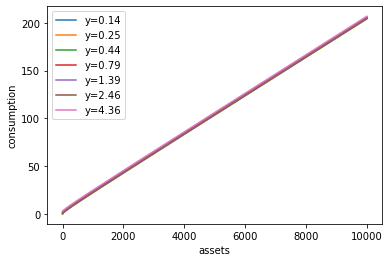

In [19]:
for s, ys in enumerate(y):
    plt.plot(a_grid, c[s, :], label=f'y={ys:.2f}')
plt.legend()
plt.xlabel('assets')
plt.ylabel('consumption');

Looking only at lower assets, we see a more interesting picture, with some of the well-known *concavity* of the consumption function for lower income states:

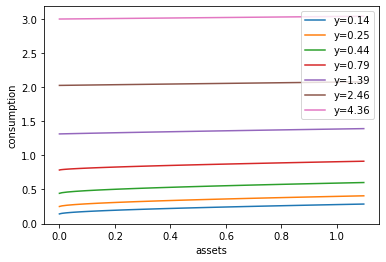

In [20]:
for s, ys in enumerate(y):
    plt.plot(a_grid[:120], c[s, :120], label=f'y={ys:.2f}')
plt.legend()
plt.xlabel('assets')
plt.ylabel('consumption');

It's even more visible if we zoom in on only the lowest income states:

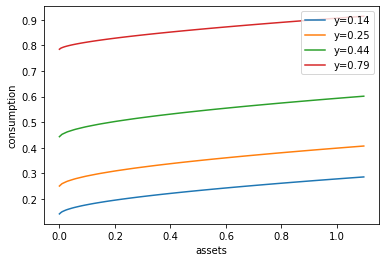

In [21]:
for s, ys in enumerate(y[:4]):
    plt.plot(a_grid[:120], c[s, :120], label=f'y={ys:.2f}')
plt.legend()
plt.xlabel('assets')
plt.ylabel('consumption');

It is also interesting to plot net saving—the increase or decrease in assets. At higher incomes, people are net savers until they reach a high level of assets. You can see how this might produce a right-skewed distribution of assets: in this case, even though we've extended the plot to much higher asset levels, savings are still positive for the highest income state $y=4.36$, while most of the lower income states either dissave until they hit zero or a very low level of assets.

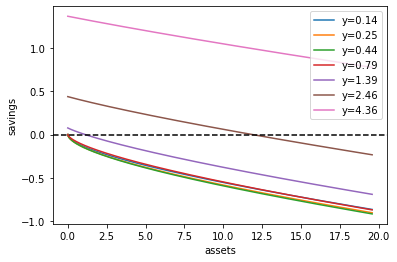

In [22]:
for s, ys in enumerate(y):
    plt.plot(a_grid[:300], a[s, :300] - a_grid[:300], label=f'y={ys:.2f}')
plt.axhline(0, linestyle='--', color='k')
plt.legend()
plt.xlabel('assets')
plt.ylabel('savings');

<a id='section3'></a>
# 3 Forward iteration to obtain the distribution

## 3.1 Policies going off the grid and the distribution
Let's take a look at the asset policy function `a` that we just obtained.

We note that generally, the asset policy function `a` will not land us at a point on the asset grid. For instance, suppose we look the asset policy for the household in the second-highest income state ($y=2.46$) with assets at the lowest gridpoint (in this case, zero):

In [23]:
a[5, 0]

0.43644603651957736

This turns out to be in between points 66 and 67 on the grid:

In [24]:
a_grid[60:70]

array([0.38029038, 0.38883467, 0.3974721 , 0.40620394, 0.41503147,
       0.423956  , 0.43297886, 0.44210141, 0.45132502, 0.46065108])

Suppose that we want to represent the joint distribution of households across states and assets. There are many possible ways we could represent this distribution, but the simplest is to discretize it using the same grid as for the policy function, keeping track of the mass at each gridpoint.

But this runs into the problem above: households starting at a gridpoint this period will generally not go to an exact gridpoint next period. How can we keep track of them, and assign them to a gridpoint?

## 3.2 Lotteries
One solution is to assume that the household follows a "lottery", going to each of the nearest two gridpoints with some probability, such that on average, the household chooses the right asset value. We can think of this as a local first-order approximation.

In particular, let the asset grid be $(a_0,\ldots,a_{n_a-1})$. If some policy $a'$ lies in between gridpoints $a_i$ and $a_{i+1}$, then we want a lottery where the household goes to $a_i$ with probability $\pi$ and $a_{i+1}$ with probability $1-\pi$, such that

$$
\pi a_i + (1-\pi) a_{i+1} = a'
$$

This can easily be solved to give

$$
\pi = (a_{i+1} - a')/(a_{i+1} - a_i) \tag{14}
$$

Note that this procedure is closely related to linear interpolation. By replacing a household at $a'$ tomorrow with a mixture of $\pi$ households at $a_i$ and $1-\pi$ households at $a_{i+1}$, we are effectively replacing any function of interest $f(a')$ for the household tomorrow, assuming we know it on the grid, by its linear interpolation $\pi f(a_i) + (1-\pi)f(a_{i+1})$.

#### Getting the lottery
We now write code that takes in an array `a` giving the policy function $a'(s,a)$, and the asset grid `a_grid`. It produces the $i(s,a)$ and $\pi(s,a)$ for the lottery corresponding to $a'(s,a)$, which we store in arrays `a_i` and `a_pi`.

This involves two steps, both for each $(s,a)$.

1. Find the $i$ such that $a'$ lies between gridpoints $a_i$ and $a_{i+1}$.


2. Implement equation (14) to obtain lottery probabilities $\pi$.

In [25]:
def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a) - 1
    
    # step 2: obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi

Let's apply this, first, to the single point `a[5,0]` we saw earlier, which as we noted was between points 66 and 67 in the grid.

In [26]:
get_lottery(a[5, 0], a_grid)

(66, 0.6199338577165254)

This gives us $i=66$ and $\pi=0.62$, with the latter indicating that `a[5,0]` is closer to gridpoint 66 than 67, and thus that 66 gets a higher weight in the lottery.

If we apply this to our entire policy function `a`, we get two arrays that have the dimensionality of the grid, with `a_i` having the integer indices $i$ and `a_pi` having the lottery probabilities $\pi$.

In [27]:
a_i, a_pi = get_lottery(a, a_grid)
a_i.shape, a_i.dtype, a_pi.shape, a_pi.dtype

((7, 500), dtype('int64'), (7, 500), dtype('float64'))

## 3.3 Using the lottery to iterate on the distribution
Now, we need to implement the lottery. Suppose that we have a discretized distribution $D(s,a)$ giving the mass at each gridpoint.

At each gridpoint, we want to send a fraction $\pi(s,a)$ of the mass to the asset gridpoint with index $i(s,a)$, and $1-\pi(s,a)$ of the mass to index $i(s,a)+1$.

This is very easy to implement directly, but a straightforward implementation uses `for` loops and be very slow in ordinary Python. Fortunately, a package called Numba allows us to accelerate compatible code by adding a simple `@numba.njit` decorator at the top of the function. This does just-in-time compilation of the code, so that after an initial compilation cost is paid on the first run, the code runs at a speed comparable to compiled languages like C and Fortran.

In [28]:
@numba.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for s in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(s,a) of the mass to gridpoint i(s,a)
            Dend[s, a_i[s,a]] += a_pi[s,a]*D[s,a]
            
            # send 1-pi(s,a) of the mass to gridpoint i(s,a)+1
            Dend[s, a_i[s,a]+1] += (1-a_pi[s,a])*D[s,a]
            
    return Dend

## 3.4 Iterating on the state as well
After households choose their new asset levels $a'$, we have the "end-of-period" distribution $D^{end}(s,a')$. But to get the distribution $D(s',a')$ at the beginning of next period, we also need to update the exogenous state $s$ to $s'$. Like in `stationary_markov` earlier, this requires matrix multiplication by the *transpose* $\Pi'$ of the Markov matrix. (Note the contrast with the first step of `backward_iteration`, where multiply by $\Pi$ itself to take expectations.)

We can now combine this with the `forward_policy` function above to get a complete forward iteration function, taking us from $D(s,a)$ to $D(s',a')$:

In [29]:
def forward_iteration(D, Pi, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return Pi.T @ Dend

## 3.5 Iterating to find stationary distribution of $(s,a)$
As an initial guess for the distribution $D(s,a)$, we'll use $D(s,a)=\frac{1}{n_a}\pi(s)$, which has the right marginal distribution of states $s$, but a uniform distribution of $a$ conditional on each $s$.

In [30]:
def distribution_ss(Pi, a, a_grid, tol=1E-10):
    a_i, a_pi = get_lottery(a, a_grid)
    
    # as initial D, use stationary distribution for s, plus uniform over a
    pi = stationary_markov(Pi)
    D = pi[:, np.newaxis] * np.ones_like(a_grid) / len(a_grid)
    
    # now iterate until convergence to acceptable threshold
    for _ in range(10_000):
        D_new = forward_iteration(D, Pi, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new

## 3.6 Getting steady-state distribution for our calibrated example
Let's apply this to our example economy. We get an $n_s\times n_a$ array giving the mass at each $D(s,a)$.

In [31]:
D = distribution_ss(Pi, a, a_grid)
D.shape

(7, 500)

How can we plot this distribution? One simple way is to look at the cumulative distribution function of assets, which we can get by summing across $s$ and then taking the cumulative sum across $a$.

Of course, we quickly see that this isn't very informative, since everyone has assets far below the top of the distribution—in this case, we made the grid maximum higher than it needed to be:

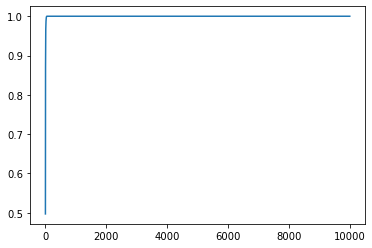

In [32]:
plt.plot(a_grid, D.sum(axis=0).cumsum());

It's much more informative to plot up to a much lower level of assets. For instance, if we plot up to approximately $a=20$ (i.e. 20 times the average quarterly income, which we normalized to one, or 5 times the average annual income), we get: 

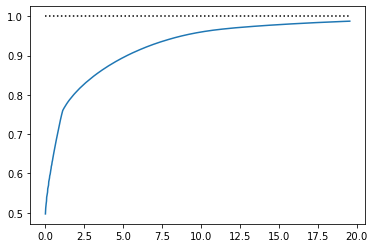

In [33]:
plt.plot(a_grid[:300], D.sum(axis=0)[:300].cumsum())
plt.hlines(1,0, a_grid[299], colors='k', linestyles='dotted');

We see that a small fraction of people have assets over $a=20$ (these people, it will turn out, account for a nontrivial portion of total assets), but that the vast majority of the distribution is much lower. Indeed, since the CDF starts at 0.5, about half of households have zero assets.

We can zoom in even further:

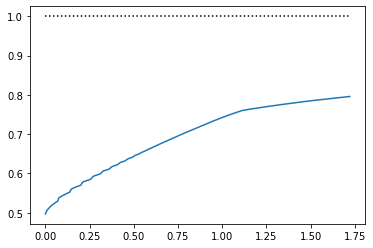

In [34]:
plt.plot(a_grid[:150], D.sum(axis=0)[:150].cumsum())
plt.hlines(1,0, a_grid[149], colors='k', linestyles='dotted');

Here we start to see some odd features. There are apparent jumps in the CDF near 0, which seem to correspond to mass points of the distribution. Then there is also a kink in the CDF a little above 1, which seems to correspond to a discontinuous drop in density.

We can better understand these features if we plot the CDF separately by income state.

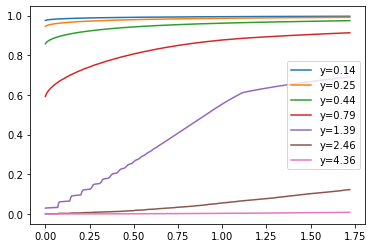

In [35]:
for s, ys in enumerate(y):
    plt.plot(a_grid[:150], D[s][:150].cumsum()/pi[s], label=f'y={ys:.2f}')
plt.legend();

Here we see it: the odd behavior is mostly in the asset distribution for the $y=1.39$ income state. This is easy to explain on theoretical grounds:

1. First, at all income states lower than $y=1.39$, households eventually draw down their assets to zero, and there is a mass point at zero assets. If their income rises to $y=1.39$, these households start saving, and there are mass points of households who have been saving for one, two, three, ... periods at this income, starting from exactly $a=0$.


2. Second, the savings function for $y=1.39$ households hits zero at slightly above 1. This is the "target" level of assets for households with $y=1.39$. Households below this level will converge to it from below, and vice versa, but no households with $y=1.39$ *cross* this level. Hence nothing enforces a continuous density, and indeed it turns out that more households are converging from below, so the density below the level is higher than above.

These seemingly-strange features of the distribution often show up in the standard incomplete markets model when we have finitely many income states. \#1 only happens because of the interaction between a mass at the binding borrowing constraint and discrete time. But \#2 can happen even in alternative models with no binding borrowing constraint, or continuous time. (There is also a possibility \#3 related to \#2 we don't see here, which is that the density at the "target" level of assets can asymptote to infinity. This happens when households converge to the target level sufficiently quickly.)

The upshot is that something like this discretized "lottery" approach is necessary to achieve fine-grained accuracy for these models: many aspects of the distribution can't be represented by traditional, smooth functional forms.

If we want the distribution to look smoother, we'd need to add some kind of shock with continuous support to the model—for instance, maybe log income has a continuously distributed iid component.

Aside from the curiosities at $y=1.39$, we can see that the asset distributions for the highest income states $y=2.46$ and $y=4.36$ are far to the right. We can get a sense of this by calculating the average level of assets at each income state:

In [36]:
for s, ys in enumerate(y):
    print(f'Ave assets at y={ys:.2f}: {np.vdot(a_grid, D[s, :]) / pi[s]:.2f}')

Ave assets at y=0.14: 0.02
Ave assets at y=0.25: 0.05
Ave assets at y=0.44: 0.16
Ave assets at y=0.79: 0.56
Ave assets at y=1.39: 2.19
Ave assets at y=2.46: 7.01
Ave assets at y=4.36: 17.67


To get a sense of *who* holds the assets, we could also simply calculate total assets held in each income bin. This shows less dominance by the highest-income types, since they are far less common (as we also display below):

In [37]:
for s, ys in enumerate(y):
    print(f'Total assets at y={ys:.2f} ({100*pi[s]:.1f}% of hh)\t: {np.vdot(a_grid, D[s, :]):.2f}')

Total assets at y=0.14 (1.6% of hh)	: 0.00
Total assets at y=0.25 (9.4% of hh)	: 0.00
Total assets at y=0.44 (23.4% of hh)	: 0.04
Total assets at y=0.79 (31.2% of hh)	: 0.17
Total assets at y=1.39 (23.4% of hh)	: 0.51
Total assets at y=2.46 (9.4% of hh)	: 0.66
Total assets at y=4.36 (1.6% of hh)	: 0.28


Of course, we can also get the sum of all these, the total assets held in the economy. (Since `a_grid` is 1-dimensional and `D` is two-dimensional, we can't directly use a dot product here, but [array broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) lines `a_grid` up with the second dimension of `D`, which is the asset dimension.)

In [38]:
np.sum(a_grid*D)

1.6645070676480893

Since we solved for a steady state, this is equal—up to numerical error—to the total assets chosen for tomorrow:

In [39]:
np.vdot(a, D)

1.6645070661939023

<a id='section4'></a>
# 4 Combining everything and aggregating: the full steady state
## 4.1 Combined steady-state function
Now we'll write a simple function that tracks everything we've done so far. Starting from the inputs to the policy function from part 2, we'll solve for both the steady-state policy function and distribution, then aggregate to obtain total consumption and assets.

We'll return a dict with all inputs to the problem (`Pi`, `a_grid`, `y`, `r`, `beta`, `eis`), the individual level policies and marginal value function (`a`, `c`, `Va`), the distribution (`D`), and aggregate policies (`A` and `C`).

In [40]:
def steady_state(Pi, a_grid, y, r, beta, eis):
    Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)
    D = distribution_ss(Pi, a, a_grid)
    
    return dict(D=D, Va=Va, 
                a=a, c=c,
                A=np.vdot(a, D), C=np.vdot(c, D), # aggregation
                Pi=Pi, a_grid=a_grid, y=y, r=r, beta=beta, eis=eis)

In [41]:
ss = steady_state(Pi, a_grid, y, r, beta, eis)
ss.keys()

dict_keys(['D', 'Va', 'a', 'c', 'A', 'C', 'Pi', 'a_grid', 'y', 'r', 'beta', 'eis'])

## 4.2 Some comparative statics
Steady-state assets slope sharply upward as we increase the steady-state real interest rate $r$, and indeed asymptote to infinity as we approach $r=\beta^{-1}-1$, which in this case is just above 0.02:

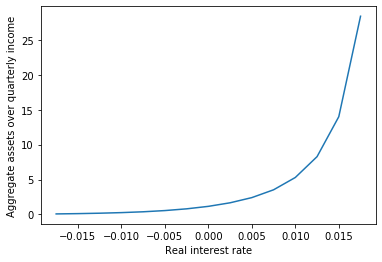

In [42]:
rs = r + np.linspace(-0.02, 0.015, 15)
As = [steady_state(Pi, a_grid, y, r, beta, eis)['A'] for r in rs]
plt.plot(rs, As)
plt.xlabel('Real interest rate')
plt.ylabel('Aggregate assets over quarterly income');

(Note that the y-axis is labeled "aggregate assets over quarterly income" because aggregate quarterly income is normalized to one, so that this is how the quantity `A` should be interpreted.)

Assets also slope strongly upward in income risk, which we'll manipulate below by calibrating to different standard deviations $\sigma$ of cross-sectional log income. (This turns out to change only the vector `y` of incomes, making them more dispersed, not the Markov matrix `Pi`.)

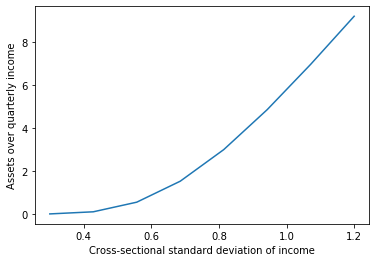

In [43]:
sigmas = np.linspace(0.3, 1.2, 8) # our benchmark was sigma=0.7
As = []
for sigma in sigmas:
    y_new, pi_new, Pi_new = discretize_income(0.975, sigma, 7)
    As.append(steady_state(Pi_new, a_grid, y_new, r, beta, eis)['A'])
plt.plot(sigmas, As)
plt.xlabel('Cross-sectional standard deviation of income')
plt.ylabel('Assets over quarterly income');

They are decreasing in the elasticity of intertemporal substitution, or equivalently increasing in the coefficient of risk aversion (its inverse)—this is because with lower risk aversion and less desire to smooth consumption, the precautionary and income-smoothing motives for saving become weaker.

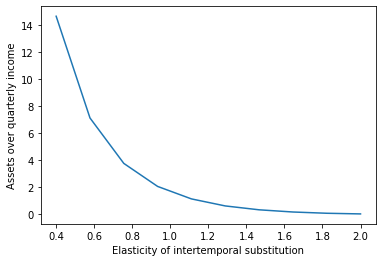

In [44]:
eis_vec = np.linspace(0.4, 2, 10) # our benchmark was eis=1
As = [steady_state(Pi, a_grid, y, r, beta, eis)['A'] for eis in eis_vec]
plt.plot(eis_vec, As)
plt.xlabel('Elasticity of intertemporal substitution')
plt.ylabel('Assets over quarterly income');

## 4.3 Calibration
So far, we've simply chosen all parameters of the household problem and then solved for the steady state. Alternatively, we might want to calibrate some of those parameters to hit various calibration targets.

For instance, we might want to choose total assets to equal a certain level relative to income, which is normalized to one. Suppose that we choose assets to equal 140% of annual household income (inspired by [McKay, Nakamura, and Steinsson](https://eml.berkeley.edu/~enakamura/papers/forwardguidance.pdf), who calibrate to 140% of annual GDP). Since we have calibrated *quarterly* income to be 1, annual income is 4, and we want aggregate assets `A` to be $4\times 1.4 = 5.6$.

We'll search for the discount factor $\beta$ that hits this calibration target. Unsurprisingly, higher $\beta$ implies higher assets: more patient households save more.

We'll use the SciPy function `optimize.brentq`, which uses [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method) (the same as in Matlab's `fzero`) to find the root of a scalar function. We need to give this method a minimum and maximum that bracket the root: as a minimum, we'll pick our existing $\beta=0.98$, which gives lower savings, and as a maximum we'll pick the high level of $\beta=0.995$. Note that we use the [Python `lambda` syntax](https://www.w3schools.com/python/python_lambda.asp) to define a new function of `beta` inline, so that the calibration code is very concise:

In [45]:
beta_calib = optimize.brentq(
                lambda beta: steady_state(Pi, a_grid, y, r, beta, eis)['A'] - 5.6,
                0.98, 0.995)

beta_calib

0.987703940322874

Let's get the entire steady state, verify that we have the right assets, and also look at consumption:

In [46]:
ss_calib = steady_state(Pi, a_grid, y, r, beta_calib, eis)
ss_calib['A'], ss_calib['C']

(5.599999999969402, 1.0140000048859799)

Indeed, we have aggregate assets equal to 5.6 as desired, and aggregate consumption equals 1.014, which we could also calculate by summing aggregate labor income (which is 1) and asset income, as $C = 1 + rA$. We see that this is accurate (up to a small numerical error):

In [47]:
1 + ss_calib['r']*ss_calib['A'] - ss_calib['C']

-4.886056448327736e-09

## 4.4 General equilibrium
So far, we have only discussed the "partial equilibrium" household problem in isolation.

Here, we briefly discuss how this household block can be embedded in general equilibrium. Suppose that the household in state $s$ has an endowment $e(s)$ of effective labor, and that we normalize average effective labor to 1. Each unit of effective labor is used to produce one unit of consumption goods by a perfectly competitive production sector, so that the real wage is 1. Households save in government bonds, which pay the real interest rate $r$ and are supplied in exogenous quantity $B$ by the government. In steady state, the government finances its interest payments using a tax $\tau = rB$ on labor earnings. Households' after-tax labor income is $y(s)=(1-\tau)e(s)$.

Suppose that we make $e(s)$ follow the same Markov process that $y(s)$ previously did, with mean 1. Then the only difference from the household sector in our previous calculations is that the after-tax income $y(s)$ that appears in households' budget constraint (2) now includes a factor of $1-\tau$.

In the spirit of the previous section, let's calibrate the ratio of bonds to output to annual 1.4, so that `B` is 5.6.

In [48]:
B = 5.6   # annual bonds/GDP is 140%, so quarterly is 560%, and quarterly GDP is 1
tau = r*B # labor tax needed to balance steady-state government budget
e = y     # use our previous y, which had mean 1, for the labor endowment process

Because of the low real interest rate, $\tau$ is quite small:

In [49]:
tau

0.013999999999999999

Now we can calibrate $\beta$ to be consistent with steady-state asset market clearing, where aggregate household assets $A$ equal the supply $B$ of bonds. Note that we use $(1-\tau)e(s)$ as income:

In [50]:
beta_ge = optimize.brentq(
                lambda beta: steady_state(Pi, a_grid, (1-tau)*e, r, beta, eis)['A'] - B,
                0.98, 0.995)

beta_ge

0.9877855433151485

Let's compute general equilibrium with this, and check that both asset market clearing and goods market clearing hold. (Note that although we are not explicitly solving for the latter, it should hold by Walras's law, with a total supply of goods equal to aggregate effective labor, which is 1.)

In [51]:
ss_ge = steady_state(Pi, a_grid, (1-tau)*e, r, beta_ge, eis)
asset_mkt = ss_ge['A'] - B
goods_mkt = ss_ge['C'] - 1
asset_mkt, goods_mkt

(-1.6627588195206044e-11, 4.785917218086411e-09)

**General equilbrium counterfactuals.** Now that we have a fully specified general equilibrium model, we can do general equilibrium comparative statics, looking at what happens as we vary some parameter and continue re-solving for general equilibrium, keeping all other parameters (including the government's exogenous supply of bonds `B`) constant.

For instance, suppose that we change income risk as in section 4.3. Now, total assets won't change, since they will equal `B`. Instead, it is the *real interest rate* $r$ that will move to equilibriate the market. As income risk rises and households desire to save more, the real interest rate decreases to maintain asset market equilibrium:

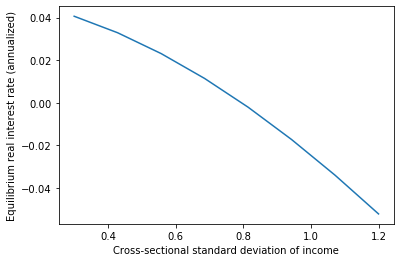

In [52]:
sigmas = np.linspace(0.3, 1.2, 8) # our benchmark was sigma=0.7
rs = []
for sigma in sigmas:
    e_new, pi_new, Pi_new = discretize_income(0.975, sigma, 7)
    rs.append(optimize.brentq(
                lambda r: steady_state(Pi_new, a_grid, (1-r*B)*e_new, r, beta_ge, eis)['A'] - B,
                -0.02, 0.015))
plt.plot(sigmas, 4*np.array(rs))
plt.xlabel('Cross-sectional standard deviation of income')
plt.ylabel('Equilibrium real interest rate (annualized)');

(Note that this calculation took some more time than the others, since we are looping over different $\sigma$s and then solving separately for the equilibrium $r$ corresponding to each. There are many ways to speed up this kinds of calculation—for instance, interpolating or extrapolating to get a better initial guess for each $r$.)